# Check GPU


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd /content/drive/MyDrive/natural-language-processing-project/

In [3]:
#!nvidia-smi


#Improved RoBERTa for PCL Detection with Enhanced Preprocessing and Hyperparameter Tuning


In [4]:
# Check GPU and install dependencies
!pip install simpletransformers tensorboardx nltk transformers tf-keras tensorflow



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import logging, random, pandas as pd, torch
from collections import Counter
from ast import literal_eval
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight



/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print('Cuda available? ', cuda_available)

if cuda_available:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


Cuda available?  False


In [7]:
# Fetch the Don't Patronize Me! data manager module
module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name, 'w') as outf:
    outf.write(f.read().decode('utf-8'))


Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [9]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('../data/train/original_data', '../data/train/original_data')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)


Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [10]:

# Load paragraph IDs for training and official dev set
trids = pd.read_csv('../data/train/sample_splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('../data/train/sample_splits/dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



In [11]:
data = dpm.train_task1_df

In [12]:

rows = []
for idx in range(len(trids)):
    parid = trids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
trdf1 = pd.DataFrame(rows)


In [13]:

# Prepend the community label as an extra feature to the text

trdf1['text'] = trdf1['community'] + ": " + trdf1['text']

# Adjust class balance (for binary Task 1: treat label==1 as positive, label==0 as negative)
# Downsample negatives to get a ~1:3 ratio with the positive (PCL) class.
pcldf = trdf1[trdf1.label == 1]
npos = len(pcldf)
balanced_df = pd.concat([pcldf, trdf1[trdf1.label == 0][:npos * 3]])
balanced_df = shuffle(balanced_df, random_state=42)
print("Balanced training set shape:", balanced_df.shape)




Balanced training set shape: (3176, 4)


In [14]:
# Augmentation: Synonym Replacement (EDA)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def synonym_replacement(text, alpha=0.1):
    words = text.split()
    new_words = []
    for word in words:
        if random.uniform(0, 1) < alpha:
            synonyms = wordnet.synsets(word)
            if synonyms:
                lemmas = synonyms[0].lemma_names()
                if lemmas:
                    new_word = random.choice(lemmas)
                    new_words.append(new_word)
                else:
                    new_words.append(word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ginevracepparulo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:

# Create augmented data by synonym replacement
augmented_rows = []
for idx, row in balanced_df.iterrows():
    new_text = synonym_replacement(row['text'], alpha=0.1)
    augmented_rows.append({
        'par_id': row['par_id'],
        'community': row['community'],
        'text': new_text,
        'label': row['label']
    })
augmented_df = pd.DataFrame(augmented_rows)
balanced_df = pd.concat([balanced_df, augmented_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After synonym augmentation:", balanced_df.shape)


After synonym augmentation: (6352, 4)


In [16]:
# Augmentation: Backtranslation (using MarianMT)
from transformers import pipeline
translator_en_to_de = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
translator_de_to_en = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en")

def backtranslate(text):
    de_text = translator_en_to_de(text)[0]['translation_text']
    en_text = translator_de_to_en(de_text)[0]['translation_text']
    return en_text

# Augment a random 20% subset via backtranslation
bt_subset = balanced_df.sample(frac=0.2, random_state=42)
backtranslated_rows = []
for idx, row in bt_subset.iterrows():
    try:
        new_text = backtranslate(row['text'])
        backtranslated_rows.append({
            'par_id': row['par_id'],
            'community': row['community'],
            'text': new_text,
            'label': row['label']
        })
    except Exception as e:
        print("Backtranslation error:", e)
backtranslated_df = pd.DataFrame(backtranslated_rows)
balanced_df = pd.concat([balanced_df, backtranslated_df])
balanced_df = shuffle(balanced_df, random_state=42)
print("After backtranslation augmentation:", balanced_df.shape)


/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use mps:0
Device set to use mps:0


After backtranslation augmentation: (7622, 4)


# Prepare Test Set for Task 1 (Official Dev Set)


In [17]:
# Rebuild dev set (Task 1) with extra feature
rows_test = []
for idx in range(len(teids)):
    parid = teids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows_test.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
tedf1 = pd.DataFrame(rows_test)

# Prepend community label to text in dev set as well
tedf1['text'] = tedf1['community'] + ": " + tedf1['text']


# Set Up Hyperparameters and Class Weights for the Model


In [52]:
#param_grid = {"lr":1e-5, "batch_size":8 ,"batch_size":32, "num_epochs":4, "num_epochs":2}
param_grid = {"batch_size":8, "num_epochs":5}

In [19]:
import numpy as np

# Compute class weights for binary classification
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=balanced_df['label'])
class_weights = class_weights.tolist()
print("Class weights:", class_weights)

Class weights: [0.6649799336939453, 2.0153358011634057]


In [21]:
# Configure hyperparameters and early stopping options
task1_model_args = ClassificationArgs(
    num_train_epochs=3,
    learning_rate=2e-5,
    train_batch_size=16,
    evaluate_during_training=True,
    evaluate_during_training_steps=100,  # adjust as needed
    early_stopping_patience=2,
    early_stopping_delta=0.001,
    save_eval_checkpoints=True,
    save_model_every_epoch=True,
    overwrite_output_dir=True,
    logging_steps=100,  # Adjust logging frequency
    save_steps=500,
    silent=False,
    #use_multiprocessing=False,
    #fp16=False
    #process_count=1,
)
# Pass computed weights
task1_model_args.weight = class_weights

In [22]:
task1_model_args.logging_level = 'debug'

In [23]:
!pip install tqdm


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [24]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
# Initialize the ClassificationModel with the improved hyperparameters
task1_model = ClassificationModel(
    "roberta",
    "roberta-base",
    args=task1_model_args,
    num_labels=2,
    use_cuda=cuda_available,
    weight=class_weights
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

import tensorflow as tf

#tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)



IndexError: list index out of range

In [27]:
tf.config.list_physical_devices('GPU')

[]

In [28]:
# Set TensorFlow logging level to INFO (higher verbosity)
tf.get_logger().setLevel('INFO')

# You can also try this for debugging (it gives more details)
tf.debugging.set_log_device_placement(True)

In [53]:
def_num_train_epochs = 3
def_learning_rate = 2e-5
def_train_batch_size = 16

In [30]:
# Helper function to save predictions
def labels2file(p, outf_path):
    with open(outf_path, 'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi]) + '\n')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tuning 1 is batch_size=8


/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/12 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

Dev Set Accuracy: 0.8968481375358166
Dev Set Macro Precision: 0.72069385772801
Dev Set Macro Recall: 0.8193288341443365
Dev Set Macro F1 Score: 0.7563983248022336

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1895
           1       0.47      0.72      0.57       199

    accuracy                           0.90      2094
   macro avg       0.72      0.82      0.76      2094
weighted avg       0.92      0.90      0.91      2094



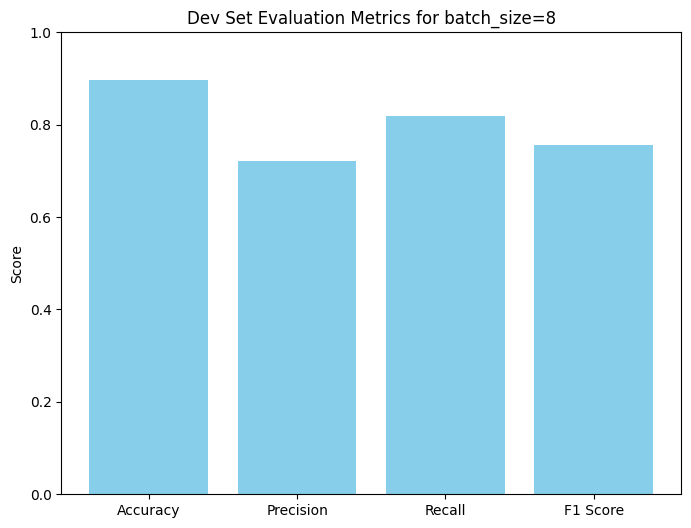

Dev Set Accuracy: 0.8968481375358166
Dev Set Precision (class 1): 0.4721311475409836
Dev Set Recall (class 1): 0.7236180904522613
Dev Set F1 Score (class 1): 0.5714285714285714


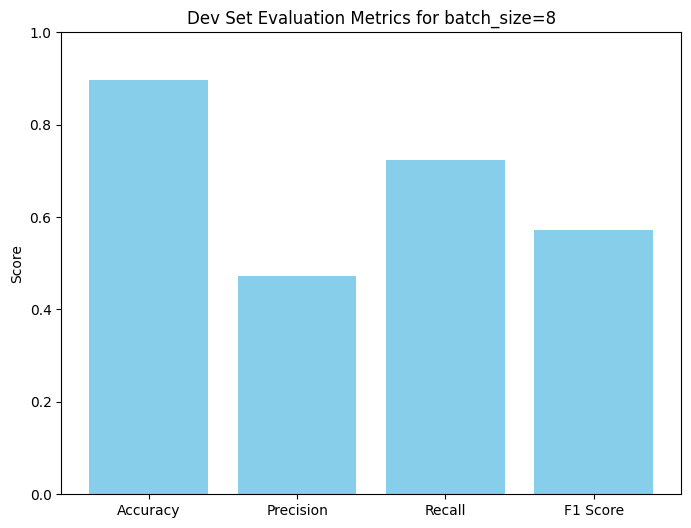

Tuning 2 is num_epochs=5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ginevracepparulo/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/70016_NLP/nlp_env/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 0/12 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning

Dev Set Accuracy: 0.9021012416427889
Dev Set Macro Precision: 0.7269634572152868
Dev Set Macro Recall: 0.8019928136725846
Dev Set Macro F1 Score: 0.756604816647058

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      1895
           1       0.49      0.68      0.57       199

    accuracy                           0.90      2094
   macro avg       0.73      0.80      0.76      2094
weighted avg       0.92      0.90      0.91      2094



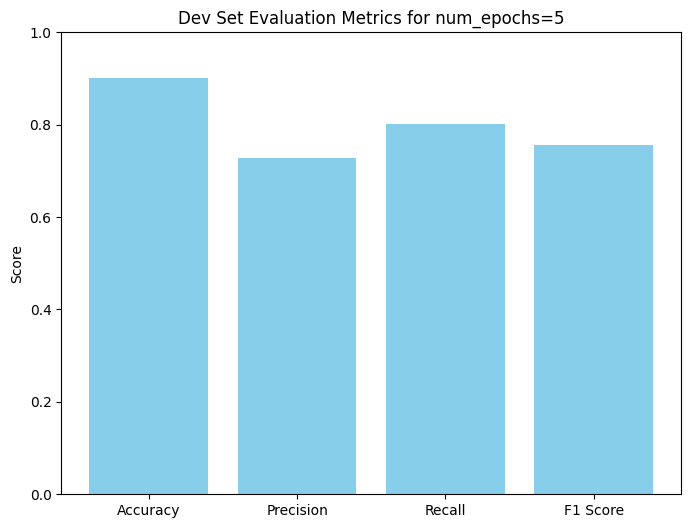

Dev Set Accuracy: 0.9021012416427889
Dev Set Precision (class 1): 0.4891304347826087
Dev Set Recall (class 1): 0.678391959798995
Dev Set F1 Score (class 1): 0.5684210526315789


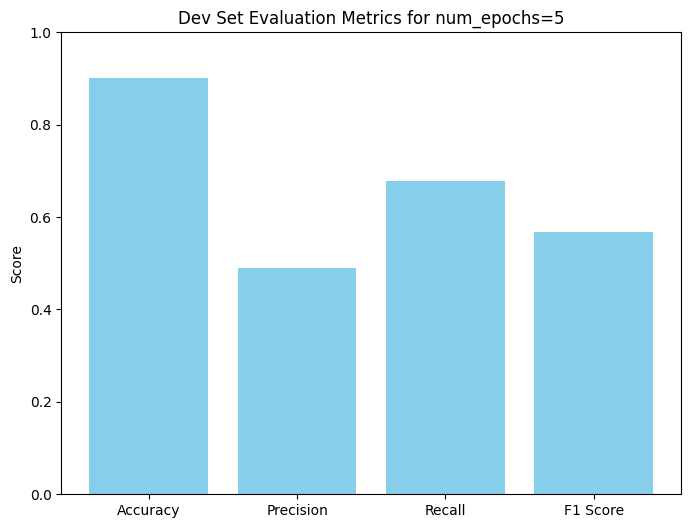

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

num_train_epochs = 3
learning_rate = 2e-5
train_batch_size = 16

best_F1 = 0
for i, (param,val) in enumerate(param_grid.items()):
    if param == "num_epochs":
      num_train_epochs = param_grid[param]
    elif param == "lr":
      learning_rate = param_grid[param]
    elif param == "batch_size":
      train_batch_size = param_grid[param]

    print(f"Tuning {i+1} is {param}={val}")

    # Configure hyperparameters and early stopping options
    task1_model_args = ClassificationArgs(
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        train_batch_size=train_batch_size,
        evaluate_during_training=True,
        evaluate_during_training_steps=100,  # adjust as needed
        early_stopping_patience=2,
        early_stopping_delta=0.001,
        save_eval_checkpoints=True,
        save_model_every_epoch=True,
        overwrite_output_dir=True,
    )
    # Pass computed weights
    task1_model_args.weight = class_weights
    # Initialize the ClassificationModel with the improved hyperparameters
    task1_model = ClassificationModel(
        "roberta",
        "roberta-base",
        args=task1_model_args,
        num_labels=2,
        use_cuda=cuda_available,
        weight=class_weights
    )

    #tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

    #task1_model.model.to(torch.device("cuda"))

    #for param in task1_model.model.parameters():
        #print(param.device)  # Should print "cuda:0" for all parameters

    train_df, eval_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

    # Train the model on the improved and augmented training set
    # Split balanced_df into training and evaluation sets (80% train, 20% eval)
    # Train the model with both training and evaluation data
    task1_model.train_model(train_df[['text', 'label']], eval_df=eval_df[['text', 'label']])

    # Run predictions on the dev set (for evaluation)
    preds_dev, _ = task1_model.predict(tedf1.text.tolist())
    #print("Dev set prediction counts:", Counter(preds_dev))

    # Save dev set predictions as dev.txt
    labels2file([[k] for k in preds_dev], f'dev_tuning_{i}.txt')

    # for macro precision, recall f1
    true_labels = tedf1['label'].tolist()
    accuracy = accuracy_score(true_labels, preds_dev)
    precision = precision_score(true_labels, preds_dev, average='macro')
    recall = recall_score(true_labels, preds_dev, average='macro')
    f1 = f1_score(true_labels, preds_dev, average='macro')

    print("Dev Set Accuracy:", accuracy)
    print("Dev Set Macro Precision:", precision)
    print("Dev Set Macro Recall:", recall)
    print("Dev Set Macro F1 Score:", f1)
    report = classification_report(true_labels, preds_dev)
    print("\nClassification Report:\n", report)

    with open(f"../tunings/classification_report_tuning_{param}_{val}.txt", "w") as f:
        f.write(report)

    # --- Plot Evaluation Metrics as a Bar Chart ---
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.title(f"Dev Set Evaluation Metrics for {param}={val}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.savefig(f"../tunings/dev_set_evaluation_metrics_tuning_{param}_{val}.pdf")
    plt.show()

    # for Class 1
    #true_labels = tedf1['label'].tolist()
    #accuracy = accuracy_score(true_labels, preds_dev)
    precision = precision_score(true_labels, preds_dev)
    recall = recall_score(true_labels, preds_dev)
    f1 = f1_score(true_labels, preds_dev)

    print("Dev Set Accuracy:", accuracy)
    print("Dev Set Precision (class 1):", precision)
    print("Dev Set Recall (class 1):", recall)
    print("Dev Set F1 Score (class 1):", f1)
    #report = classification_report(true_labels, preds_dev)
    #print("\nClassification Report:\n", report)

    with open(f"../tunings/classification_report_tuning_{param}_{val}_class1.txt", "w") as f:
        f.write(report)

    # --- Plot Evaluation Metrics as a Bar Chart ---
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.title(f"Dev Set Evaluation Metrics for {param}={val}")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.savefig(f"../tunings/dev_set_evaluation_metrics_tuning_{param}_{val}_class1.pdf")
    plt.show()

    if f1 > best_F1:
        best_F1 = f1
        best_model = task1_model
        best_params = {
            'num_train_epochs': num_train_epochs,
            'learning_rate': learning_rate,
            'train_batch_size': train_batch_size
        }

# Evaluation and Visualization on the Dev Set


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --- Compute Evaluation Metrics on the Dev Set ---
true_labels = tedf1['label'].tolist()
accuracy = accuracy_score(true_labels, preds_dev)
precision = precision_score(true_labels, preds_dev)
recall = recall_score(true_labels, preds_dev)
f1 = f1_score(true_labels, preds_dev)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
report = classification_report(true_labels, preds_dev)
print("\nClassification Report:\n", report)

# --- Plot Evaluation Metrics as a Bar Chart ---
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

# Load Official Test Set and Predict (Using task4_test.tsv)


In [ ]:
# Load the official test set (note: no labels available)
official_test_df = pd.read_csv('./data/test.tsv', sep='\t', header=None, names=['text'])
# If necessary, add any preprocessing (e.g., if extra features are needed, modify accordingly)

# Run predictions on the official test set
preds_test, _ = task1_model.predict(official_test_df['text'].tolist())
print("Official Test Prediction counts:", Counter(preds_test))

# Save official test set predictions as test.txt
labels2file([[k] for k in preds_test], 'test.txt')


# Prepare Submission

In [ ]:
!cat dev.txt | head -n 10
!cat test.txt | head -n 10
!zip submission_improved.zip dev.txt test.txt


